In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
import os
import xgboost as xgb
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

import cv2
%matplotlib inline
sns.set_style("dark")
import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_image_data(folder_benign='../data/resized/benign', folder_malignant='../data/resized/malignant'):
    ims_benign = np.array([cv2.imread(os.path.join(folder_benign, filename)) for filename in os.listdir(folder_benign)])
    ims_malignant = np.array([cv2.imread(os.path.join(folder_malignant, filename)) for filename in os.listdir(folder_malignant)])
    print(f"Benign images vector shape: {ims_benign.shape}")
    print(f"Malignant images vector shape: {ims_malignant.shape}")
    return ims_benign, ims_malignant

In [4]:
def flatten_image_vectors_and_generate_labels(ims_benign, ims_malignant):
    X_benign = ims_benign.flatten().reshape(ims_benign.shape[0], ims_benign.shape[1] * ims_benign.shape[2] * ims_benign.shape[3])
    X_malinant = ims_malignant.flatten().reshape(ims_malignant.shape[0], ims_malignant.shape[1] * ims_malignant.shape[2] * ims_malignant.shape[3])
    return X_benign, X_malinant

In [5]:
def get_test_train_data(X_benign, X_malinant, seed, scaled=True):
    X_train_benign, X_test_benign, Y_train_benign, Y_test_benign = train_test_split(X_benign, np.zeros(X_benign.shape[0]), test_size=0.1, random_state=seed)
    X_train_malinant, X_test_malinant, Y_train_malinant, Y_test_malinant = train_test_split(X_malinant, np.ones(X_malinant.shape[0]), test_size=0.1, random_state=seed)
    X_train = np.concatenate((X_train_benign, X_train_malinant), axis=0)
    Y_train = np.concatenate((Y_train_benign, Y_train_malinant), axis=0)
    X_test = np.concatenate((X_test_benign, X_test_malinant), axis=0)
    Y_test = np.concatenate((Y_test_benign, Y_test_malinant), axis=0)
    if scaled:
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled, Y_train, Y_test
    return (X_train, X_test, Y_train, Y_test)

In [29]:
seed=42
ims_benign, ims_malignant = load_image_data('../data/resized_600_450/benign', '../data/resized_600_450/malignant/')
X_benign,X_malinant = flatten_image_vectors_and_generate_labels(ims_benign=ims_benign, ims_malignant=ims_malignant)
X = np.concatenate((X_benign, X_malinant), axis=0)
Y = np.concatenate((np.zeros(X_benign.shape[0]), np.ones(X_malinant.shape[0])))
# X_train_full, X_test_full, Y_train_full, Y_test_full = get_test_train_data(X_benign=X_benign, X_malinant=X_malinant, seed=seed)
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
# X_test = scaler.transform(X_test_full)
pca = PCA(.998)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)


Benign images vector shape: (150, 450, 600, 3)
Malignant images vector shape: (150, 450, 600, 3)


In [30]:
seed = 42
num_trees=150
models = {
     'SVM' : svm.SVC(random_state=42, gamma='scale'),
     'LDA' : LinearDiscriminantAnalysis(),
     'XGBoost' : xgb.XGBClassifier(),
     'RF': RandomForestClassifier(n_estimators=num_trees, random_state=seed),
     'LR':LogisticRegression(solver='lbfgs', max_iter=1000)
 }

Model:SVM --> Mean:[0.5866666666666667] , STD:[0.11274356350191841]
Model:LDA --> Mean:[0.52] , STD:[0.0805536398239638]
Model:XGBoost --> Mean:[0.5933333333333333] , STD:[0.11333333333333334]
Model:RF --> Mean:[0.6233333333333334] , STD:[0.0683942817622773]
Model:LR --> Mean:[0.5599999999999999] , STD:[0.08793937305515277]


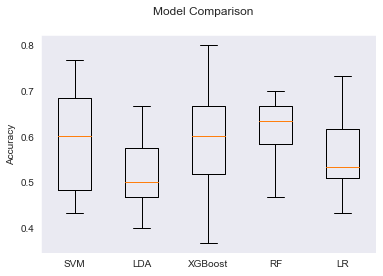

In [31]:
results = []
names =[]
for name, model in models.items():
    cv_results = cross_val_score(model, X_pca, Y, cv=KFold(n_splits=10), scoring="accuracy", n_jobs=-1)
    print(f"Model:{name} --> Mean:[{cv_results.mean()}] , STD:[{cv_results.std()}]")
    names.append(name)
    results.append(cv_results)
fig = plt.figure()
fig.suptitle(f'Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel("Accuracy")
plt.show()

In [32]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3, cv=KFold(n_splits=10), n_jobs=5)   
grid.fit(X_pca, Y)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 241 out of 250 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    2.3s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=5,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [49]:
X_train,X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.2)

In [52]:
Cs = [0.1, 1, 10, 15, 20, 100]
gammas= [1, 0.1, 0.01, 0.001, 0.0001]

accuracy = []
for C in Cs:
    for gamma in gammas:
        clf = svm.SVC(C=C, gamma=gamma, kernel='linear')
        clf.fit(X_train, Y_train)
        pred = clf.predict(X_test)
        accuracy.append((C, gamma, accuracy_score(Y_test, pred)))

In [53]:
accuracy

[(0.1, 1, 0.6166666666666667),
 (0.1, 0.1, 0.6166666666666667),
 (0.1, 0.01, 0.6166666666666667),
 (0.1, 0.001, 0.6166666666666667),
 (0.1, 0.0001, 0.6166666666666667),
 (1, 1, 0.6166666666666667),
 (1, 0.1, 0.6166666666666667),
 (1, 0.01, 0.6166666666666667),
 (1, 0.001, 0.6166666666666667),
 (1, 0.0001, 0.6166666666666667),
 (10, 1, 0.6166666666666667),
 (10, 0.1, 0.6166666666666667),
 (10, 0.01, 0.6166666666666667),
 (10, 0.001, 0.6166666666666667),
 (10, 0.0001, 0.6166666666666667),
 (15, 1, 0.6166666666666667),
 (15, 0.1, 0.6166666666666667),
 (15, 0.01, 0.6166666666666667),
 (15, 0.001, 0.6166666666666667),
 (15, 0.0001, 0.6166666666666667),
 (20, 1, 0.6166666666666667),
 (20, 0.1, 0.6166666666666667),
 (20, 0.01, 0.6166666666666667),
 (20, 0.001, 0.6166666666666667),
 (20, 0.0001, 0.6166666666666667),
 (100, 1, 0.6166666666666667),
 (100, 0.1, 0.6166666666666667),
 (100, 0.01, 0.6166666666666667),
 (100, 0.001, 0.6166666666666667),
 (100, 0.0001, 0.6166666666666667)]

In [13]:
xgb_model = xgb.XGBClassifier()
eval_set = [(X_train_p, Y_train_full), (X_test_p, Y_test_full)]
eval_metric = ["auc", "error"]
%time xgb_model.fit(X_train_p, Y_train_full, eval_metric=eval_metric, eval_set=eval_set, verbose=True)


[0]	validation_0-auc:0.844938	validation_0-error:0.17037	validation_1-auc:0.84	validation_1-error:0.2
[1]	validation_0-auc:0.893443	validation_0-error:0.181481	validation_1-auc:0.84	validation_1-error:0.266667
[2]	validation_0-auc:0.922798	validation_0-error:0.159259	validation_1-auc:0.817778	validation_1-error:0.233333
[3]	validation_0-auc:0.933909	validation_0-error:0.159259	validation_1-auc:0.78	validation_1-error:0.266667
[4]	validation_0-auc:0.945487	validation_0-error:0.144444	validation_1-auc:0.773333	validation_1-error:0.3
[5]	validation_0-auc:0.954348	validation_0-error:0.140741	validation_1-auc:0.775556	validation_1-error:0.333333
[6]	validation_0-auc:0.954595	validation_0-error:0.125926	validation_1-auc:0.775556	validation_1-error:0.233333
[7]	validation_0-auc:0.961317	validation_0-error:0.125926	validation_1-auc:0.768889	validation_1-error:0.233333
[8]	validation_0-auc:0.969904	validation_0-error:0.107407	validation_1-auc:0.757778	validation_1-error:0.266667
[9]	validation_

[78]	validation_0-auc:1	validation_0-error:0	validation_1-auc:0.773333	validation_1-error:0.233333
[79]	validation_0-auc:1	validation_0-error:0	validation_1-auc:0.773333	validation_1-error:0.233333
[80]	validation_0-auc:1	validation_0-error:0	validation_1-auc:0.777778	validation_1-error:0.233333
[81]	validation_0-auc:1	validation_0-error:0	validation_1-auc:0.777778	validation_1-error:0.233333
[82]	validation_0-auc:1	validation_0-error:0	validation_1-auc:0.773333	validation_1-error:0.233333
[83]	validation_0-auc:1	validation_0-error:0	validation_1-auc:0.773333	validation_1-error:0.233333
[84]	validation_0-auc:1	validation_0-error:0	validation_1-auc:0.768889	validation_1-error:0.233333
[85]	validation_0-auc:1	validation_0-error:0	validation_1-auc:0.773333	validation_1-error:0.233333
[86]	validation_0-auc:1	validation_0-error:0	validation_1-auc:0.773333	validation_1-error:0.233333
[87]	validation_0-auc:1	validation_0-error:0	validation_1-auc:0.777778	validation_1-error:0.233333
[88]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [18]:
xgb_model.evals_result_['validation_1'].keys()

dict_keys(['auc', 'error'])

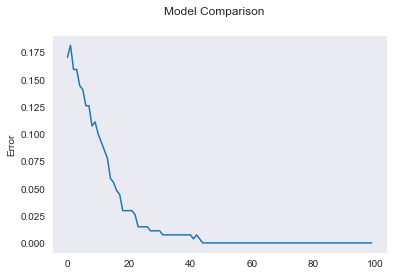

In [24]:
fig = plt.figure()
fig.suptitle(f'Model Comparison')
ax = fig.add_subplot(111)
plt.plot(xgb_model.evals_result_['validation_0']['error'])
# ax.set_xticklabels(names)
plt.ylabel("Error")
plt.show()